# Imports & Environment Setup
 Purpose:
   - Import all libraries used across the project (EDA → FE → ML → Viz)
   - Set reproducibility (random seeds)
   - Create standard project folders
   - Print library versions for auditability/defense


In [ ]:
# ---------- Core ----------
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd

# ---------- EDA (manual) ----------
import matplotlib.pyplot as plt
import seaborn as sns
import unidecode  # text normalization

# ---------- Feature Engineering ----------
import featuretools as ft
from featuretools.selection import remove_low_information_features

# ---------- Modeling ----------
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    precision_recall_fscore_support,
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import catboost
from catboost import CatBoostClassifier

# ---------- Interpretability ----------
import shap

# ---------- Visualization (interactive; used later) ----------
import plotly.express as px
import plotly.graph_objects as go
import folium
from folium.plugins import HeatMap

# ---------- Deployment (potential; for final deliverable) ----------
import streamlit as st

# ---------- Housekeeping ----------
import warnings
warnings.filterwarnings("ignore")

# ---------- Reproducibility ----------
PROJECT_SEED = 42
random.seed(PROJECT_SEED)
np.random.seed(PROJECT_SEED)

# ---------- Folders ----------
REPORTS_PATH = Path("reports")
STAGE_PATH = Path("stage")
DATA_PATH = Path("data/olist")  # expected location for Olist CSVs

REPORTS_PATH.mkdir(parents=True, exist_ok=True)
STAGE_PATH.mkdir(parents=True, exist_ok=True)

# ---------- Style (matplotlib static plots) ----------
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

# ---------- Manual cleaning utilities (deterministic & defense-ready) ----------
def standardize_headers(df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardize column headers to snake_case alphanumerics:
      - strip, lower, spaces/slashes -> underscores
      - drop non [0-9a-zA-Z_]
    """
    cols = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(r"[ /]+", "_", regex=True)
        .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
    )
    df = df.copy()
    df.columns = cols
    return df

def parse_dates(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    """
    Coerce listed columns to datetime; invalid -> NaT (no crashes).
    """
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce", utc=False)
    return df

def normalize_categoricals(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    """
    Trim whitespace & lowercase selected object columns for category hygiene.
    """
    df = df.copy()
    for c in cols:
        if c in df.columns and df[c].dtype == "object":
            df[c] = df[c].str.strip().str.lower()
    return df

# ---------- Minimal EDA helper (portable & reproducible) ----------
def quick_profile(df: pd.DataFrame, name: str = "DataFrame", top_n: int = 5):
    """
    Print a compact, reproducible profile:
      - shape, memory usage
      - dtypes summary
      - missingness table (count & %)
      - numeric describe()
      - top categories for object columns
      - missingness visual (matrix)
    """
    print(f"=== {name}: shape {df.shape} ===")
    mem_mb = df.memory_usage(deep=True).sum() / (1024**2)
    print(f"Memory: {mem_mb:.2f} MB")
    print("\nDtypes:\n", df.dtypes.value_counts())
    miss = df.isna().sum().to_frame("missing_count")
    miss["missing_pct"] = (miss["missing_count"] / len(df)).round(4)
    print("\nMissingness (top 20):\n", miss.sort_values("missing_pct", ascending=False).head(20))

    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) > 0:
        print("\nNumeric summary (describe):")
        display(df[num_cols].describe().T)

    obj_cols = df.select_dtypes(include=["object"]).columns
    for c in obj_cols[:10]:  # cap to first 10 object cols for brevity
        vc = df[c].value_counts(dropna=False).head(top_n)
        print(f"\nTop {top_n} categories in '{c}':")
        print(vc)

    # Visual missingness overview
    try:
        msno.matrix(df.sample(min(5000, len(df)), random_state=PROJECT_SEED))
        plt.title(f"Missingness Matrix — {name}")
        plt.show()
    except Exception:
        pass  # plotting is best-effort; skip on headless environments

# ---------- Versions ----------
def print_versions():
    """Print key library versions for reproducibility & grader audit."""
    import sys, sklearn, plotly, folium as _folium
    print("Python:", sys.version.split()[0])
    print("pandas:", pd.__version__)
    print("numpy:", np.__version__)
    print("featuretools:", ft.__version__)
    print("scikit-learn:", sklearn.__version__)
    print("xgboost:", xgb.__version__)
    print("catboost:", catboost.__version__)
    print("plotly:", plotly.__version__)
    print("folium:", _folium.__version__)
    print("shap:", shap.__version__)


print_versions()

# inline matplotlib plots in Jupyter
%matplotlib inline

Python: 3.12.11
pandas: 2.3.3
numpy: 2.3.3
featuretools: 1.31.0
scikit-learn: 1.6.1
xgboost: 3.0.5
catboost: 1.2.8
plotly: 5.24.1
folium: 0.20.0
shap: 0.48.0


# Load raw Olist tables (with validations)
 Requirements:
   - DATA_PATH points to the folder containing Olist CSVs
   - We load only the necessary tables for delay prediction

   We’ll keep everything in-memory (no intermediate file saves yet) to reduce complexity. After loading, we’ll print basic shapes and sample rows to confirm data integrity before EDA.


In [ ]:
# --- Define the expected files (key tables for the project) ---
expected_files = {
    "orders": "olist_orders_dataset.csv",
    "items": "olist_order_items_dataset.csv",
    "customers": "olist_customers_dataset.csv",
    "sellers": "olist_sellers_dataset.csv",
    "products": "olist_products_dataset.csv",
    "translation": "product_category_name_translation.csv",
}

# --- Validate presence and report any missing files early (defense-friendly) ---
missing = [name for name, fname in expected_files.items() if not (DATA_PATH / fname).exists()]
if missing:
    print("⚠️ Missing files in", DATA_PATH.resolve())
    for name in missing:
        print(f"  - {name}: {expected_files[name]}")
    raise FileNotFoundError(
        "One or more required Olist CSVs are missing. "
        "Download the Olist dataset and place the files under DATA_PATH."
    )

# --- Load CSVs into DataFrames (dtype inference left to pandas for now) ---
orders     = pd.read_csv(DATA_PATH / expected_files["orders"])
items      = pd.read_csv(DATA_PATH / expected_files["items"])
customers  = pd.read_csv(DATA_PATH / expected_files["customers"])
sellers    = pd.read_csv(DATA_PATH / expected_files["sellers"])
products   = pd.read_csv(DATA_PATH / expected_files["products"])
translation= pd.read_csv(DATA_PATH / expected_files["translation"])

# --- Basic integrity prints: shapes and a couple of columns to orient ourselves ---
print("Loaded tables:")
print(f"  orders     : {orders.shape}")
print(f"  items      : {items.shape}")
print(f"  customers  : {customers.shape}")
print(f"  sellers    : {sellers.shape}")
print(f"  products   : {products.shape}")
print(f"  translation: {translation.shape}")

# --- Peek at first rows (abbreviated) to confirm columns look right ---
print("\norders sample:")
display(orders.head(3))
print("\nitems sample:")
display(items.head(3))
print("\nproducts sample:")
display(products.head(3))
print("\ncustomers sample:")
display(customers.head(3))
print("\nsellers sample:")
display(sellers.head(3))
print("\ntranslation sample:")
display(translation.head(3))

# --- Quick, reproducible profile snippets (compact) ---
# Note: We use quick_profile() later per table during EDA; here we just confirm load success.


Loaded tables:
  orders     : (99441, 8)
  items      : (112650, 7)
  customers  : (99441, 5)
  sellers    : (3095, 4)
  products   : (32951, 9)
  translation: (71, 2)

orders sample:


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00



items sample:


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87



products sample:


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0



customers sample:


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP



sellers sample:


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ



translation sample:


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto


## Initial EDA Snapshots & Missingness Analysis

- Translate product categories (Portuguese → English) and normalize for readability.

- Normalize customer/seller states (abbrev → full English) and cities (remove accents).

- Drop Portuguese review text fields (not needed for delay modeling).

- Produce four slide-ready visuals using the translated/normalized data:

- Orders per year

- Delivery time distribution (days)

- Top 10 product categories (English)

- Missingness heatmap (% by column)

✅ Product category translation complete.
Unique categories: before=73 → after=72
Untranslated (set to 'Unknown'): 623


,product_id,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,Perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,Art
2,96bd76ec8810374ed1b65e291975717f,Sports Leisure
3,cef67bcfe19066a932b7673e239eb23d,Baby
4,9dc1a7de274444849c219cff195d0b71,Housewares
5,41d3672d4792049fa1779bb35283ed13,Musical Instruments
6,732bd381ad09e530fe0a5f457d81becb,Cool Stuff
7,2548af3e6e77a690cf3eb6368e9ab61e,Furniture Decor


✅ Customer/Seller states & cities normalized.


,customer_city,customer_state
0,Franca,Sao Paulo
1,Sao Bernardo Do Campo,Sao Paulo
2,Sao Paulo,Sao Paulo
3,Mogi Das Cruzes,Sao Paulo
4,Campinas,Sao Paulo


,seller_city,seller_state
0,Campinas,Sao Paulo
1,Mogi Guacu,Sao Paulo
2,Rio De Janeiro,Rio De Janeiro
3,Sao Paulo,Sao Paulo
4,Braganca Paulista,Sao Paulo


✅ Dropped review text fields if present (not needed for delay modeling).


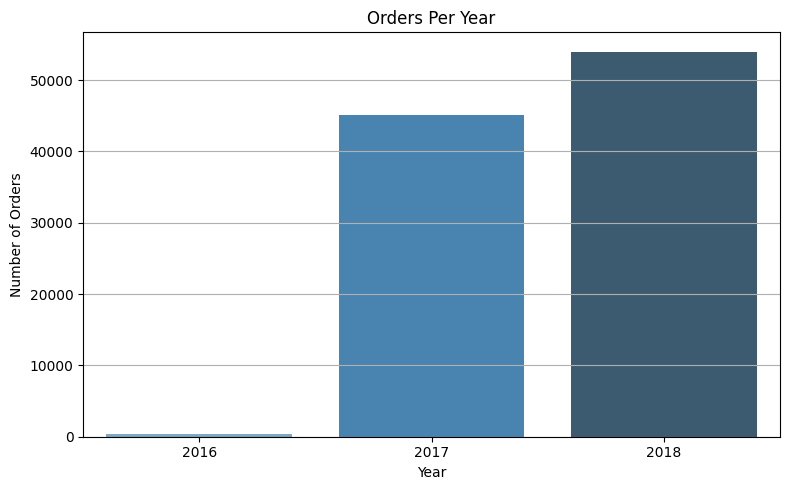

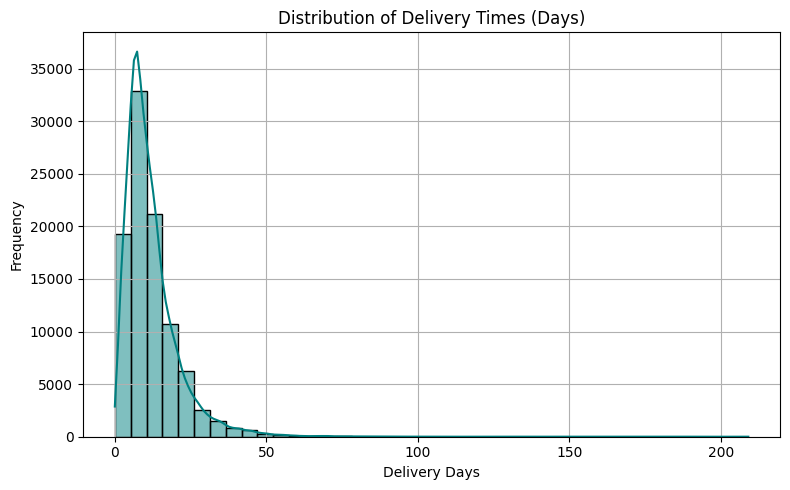

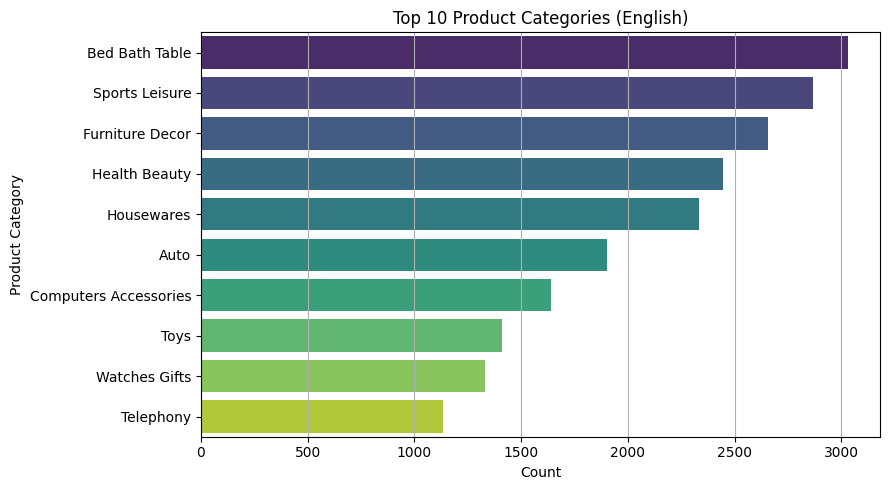

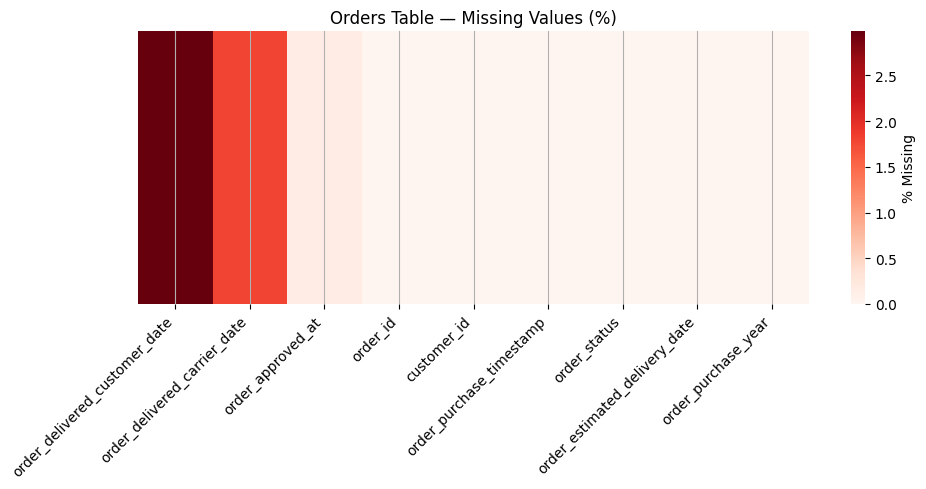

In [ ]:
#----------- Utilities for accent stripping (robust import) ----------
try:

    def strip_accents(s: str) -> str:
        return unidecode.unidecode(str(s))
except Exception:
    import unicodedata
    def strip_accents(s: str) -> str:
        return "".join(
            ch for ch in unicodedata.normalize("NFKD", str(s))
            if not unicodedata.combining(ch)
        )

# ---------- Standardize headers for consistent joins ----------
products    = standardize_headers(products)
translation = standardize_headers(translation)
customers   = standardize_headers(customers)
sellers     = standardize_headers(sellers)
orders      = standardize_headers(orders)   # also standardize orders now for visual prep

# ---------- Translate product categories (Portuguese → English) ----------
# Sanity checks
req_prod = {"product_category_name"}
req_tran = {"product_category_name", "product_category_name_english"}
assert req_prod.issubset(products.columns),  f"Missing in products: {req_prod - set(products.columns)}"
assert req_tran.issubset(translation.columns), f"Missing in translation: {req_tran - set(translation.columns)}"

unique_before = products["product_category_name"].nunique(dropna=True)

# Merge translation
products = products.merge(
    translation[["product_category_name", "product_category_name_english"]],
    how="left",
    on="product_category_name",
    validate="m:1"
)

# Replace with English; fallback to 'Unknown' where missing
products["product_category_name"] = (
    products["product_category_name_english"].fillna("Unknown")
)
products.drop(columns=["product_category_name_english"], inplace=True)

# Normalize for slides: underscores → spaces, Title Case
products["product_category_name"] = (
    products["product_category_name"]
    .astype(str)
    .str.replace("_", " ", regex=False)
    .str.strip()
    .str.title()
)

unique_after = products["product_category_name"].nunique(dropna=True)
untranslated = (products["product_category_name"] == "Unknown").sum()

print("✅ Product category translation complete.")
print(f"Unique categories: before={unique_before} → after={unique_after}")
print(f"Untranslated (set to 'Unknown'): {untranslated}")
display(products[["product_id", "product_category_name"]].head(8))

# ---------- Normalize customers/sellers (states & cities) ----------
# Map Brazilian state abbreviations → full English names
state_map = {
    "AC": "Acre", "AL": "Alagoas", "AP": "Amapa", "AM": "Amazonas", "BA": "Bahia",
    "CE": "Ceara", "DF": "Federal District", "ES": "Espirito Santo", "GO": "Goias",
    "MA": "Maranhao", "MT": "Mato Grosso", "MS": "Mato Grosso Do Sul", "MG": "Minas Gerais",
    "PA": "Para", "PB": "Paraiba", "PR": "Parana", "PE": "Pernambuco", "PI": "Piaui",
    "RJ": "Rio De Janeiro", "RN": "Rio Grande Do Norte", "RS": "Rio Grande Do Sul",
    "RO": "Rondonia", "RR": "Roraima", "SC": "Santa Catarina", "SP": "Sao Paulo",
    "SE": "Sergipe", "TO": "Tocantins"
}

# Map states (fallback to original if an unexpected code appears)
if "customer_state" in customers.columns:
    customers["customer_state"] = customers["customer_state"].map(state_map).fillna(customers["customer_state"])
if "seller_state" in sellers.columns:
    sellers["seller_state"] = sellers["seller_state"].map(state_map).fillna(sellers["seller_state"])

# Normalize city names (remove accents, title case)
if "customer_city" in customers.columns:
    customers["customer_city"] = customers["customer_city"].apply(lambda x: strip_accents(x).title())
if "seller_city" in sellers.columns:
    sellers["seller_city"] = sellers["seller_city"].apply(lambda x: strip_accents(x).title())

print("✅ Customer/Seller states & cities normalized.")
display(customers[["customer_city","customer_state"]].head(5))
display(sellers[["seller_city","seller_state"]].head(5))

# ---------- Drop Portuguese review text fields if present ----------
for col in ["review_comment_message", "review_comment_title"]:
    if col in orders.columns:
        orders.drop(columns=[col], inplace=True, errors="ignore")
print("✅ Dropped review text fields if present (not needed for delay modeling).")

# ---------- Minimal date parsing for visuals (full parsing repeated in Step 4) ----------
orders = parse_dates(orders, [
    "order_purchase_timestamp",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
])

# ---------- Slide-ready visuals (translated/normalized) ----------

# A) Orders per year (trend)
orders["order_purchase_year"] = orders["order_purchase_timestamp"].dt.year
plt.figure(figsize=(8,5))
sns.countplot(x="order_purchase_year", data=orders, palette="Blues_d")
plt.title("Orders Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.show()

# B) Delivery time distribution (days) — delivered orders only
mask_delivered = orders["order_delivered_customer_date"].notna()
delivery_days = (
    orders.loc[mask_delivered, "order_delivered_customer_date"] -
    orders.loc[mask_delivered, "order_purchase_timestamp"]
).dt.days

plt.figure(figsize=(8,5))
sns.histplot(delivery_days, bins=40, kde=True, color="teal")
plt.title("Distribution of Delivery Times (Days)")
plt.xlabel("Delivery Days")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# C) Top 10 product categories (English)
top_products_en = products["product_category_name"].value_counts().head(10)
plt.figure(figsize=(9,5))
sns.barplot(x=top_products_en.values, y=top_products_en.index, palette="viridis")
plt.title("Top 10 Product Categories (English)")
plt.xlabel("Count")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()

# D) Missingness heatmap (% by column) — Orders table
missing_pct = (orders.isna().mean().sort_values(ascending=False) * 100).to_frame("missing_pct")
plt.figure(figsize=(10,5))
sns.heatmap(missing_pct.T, cmap="Reds", cbar_kws={"label": "% Missing"})
plt.title("Orders Table — Missing Values (%)")
plt.xticks(rotation=45, ha="right")
plt.yticks([])
plt.tight_layout()
plt.show()


# Timestamp Standardization, Anomaly Repair & Data-Quality Assertions
Goals

    - Parse all order timestamps needed for delay logic.

    - Detect and repair invalid carrier handoff times (e.g., earlier than purchase) by setting them to NaT.

    - Enforce logical ordering with assertions:

        - purchase ≤ carrier ≤ delivered_customer (when present)

        - purchase ≤ estimated_delivery

    -Report missingness on key fields and show quick QC summaries/plots for delivery vs estimated days.

We won’t drop rows yet; we’ll measure and validate first. In Step 4, we’ll compute delivery_days, estimated_days, and the late label, then decide how to handle rows lacking what we need.

Carrier < Purchase anomalies: 166
Carrier > Customer Delivery anomalies: 23
Repaired carrier timestamps (set to NaT): 189
✅ Timestamp ordering validated.

Missingness on key timestamp columns (% of rows):


,missing_pct
order_delivered_customer_date,2.98
order_delivered_carrier_date,1.98
order_approved_at,0.16
order_estimated_delivery_date,0.00



QC — Delivery Days (non-Na): count= 96476 mean= 12.09 p95= 29.0
QC — Estimated Days (non-Na): count= 99441 mean= 23.4 p95= 38.0


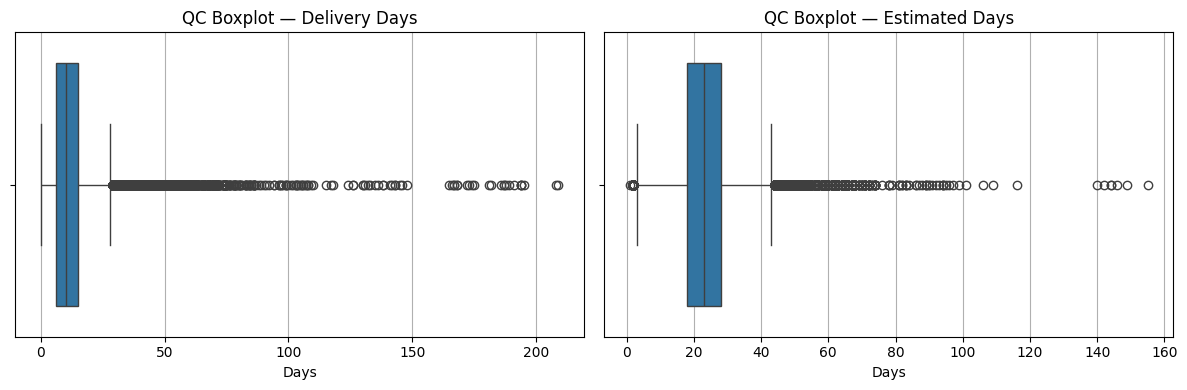

In [ ]:
# Parse all relevant order timestamps (idempotent)
orders = parse_dates(orders, [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
])

# Structural checks (fail-fast, but permissive to optional fields)
assert orders["order_id"].is_unique, "Duplicate order_id found."
assert orders["order_purchase_timestamp"].notna().all(), "Missing purchase timestamps."

# Helper for conditional ordering checks (ignores NaT pairs)
def _leq(a: pd.Series, b: pd.Series) -> bool:
    mask = a.notna() & b.notna()
    return (a[mask] <= b[mask]).all()

# INITIAL logical ordering checks (may fail if data has anomalies)

# Detect & repair invalid carrier handoff timestamps
purch = orders["order_purchase_timestamp"]
carri = orders.get("order_delivered_carrier_date", pd.Series(index=orders.index, dtype="datetime64[ns]"))
deliv = orders.get("order_delivered_customer_date", pd.Series(index=orders.index, dtype="datetime64[ns]"))

bad_carrier_before_purchase = carri.notna() & purch.notna() & (carri < purch)
bad_carrier_after_delivery  = carri.notna() & deliv.notna() & (carri > deliv)

n_before = int(bad_carrier_before_purchase.sum())
n_after  = int(bad_carrier_after_delivery.sum())

print(f"Carrier < Purchase anomalies: {n_before}")
print(f"Carrier > Customer Delivery anomalies: {n_after}")

if n_before > 0 or n_after > 0:
    to_null = bad_carrier_before_purchase | bad_carrier_after_delivery
    orders.loc[to_null, "order_delivered_carrier_date"] = pd.NaT
    print(f"Repaired carrier timestamps (set to NaT): {int(to_null.sum())}")

# FINAL logical ordering assertions (after repair)
assert _leq(orders["order_purchase_timestamp"], orders["order_delivered_customer_date"]), \
    "Deliveries earlier than purchase remain after repair."
assert _leq(orders["order_purchase_timestamp"], orders["order_estimated_delivery_date"]), \
    "Estimated delivery earlier than purchase detected."

if "order_delivered_carrier_date" in orders.columns:
    assert _leq(orders["order_purchase_timestamp"], orders["order_delivered_carrier_date"]), \
        "Carrier handoff earlier than purchase remains after repair."
    assert _leq(orders["order_delivered_carrier_date"], orders["order_delivered_customer_date"]), \
        "Customer delivery earlier than carrier handoff remains after repair."

print("✅ Timestamp ordering validated.")

# Missingness on key fields (to inform label computation)
key_cols = [
    "order_estimated_delivery_date",
    "order_delivered_customer_date",
    "order_delivered_carrier_date",
    "order_approved_at",
]
missing_summary = (
    orders[key_cols]
    .isna()
    .mean()
    .to_frame("missing_pct")
    .assign(missing_pct=lambda d: (d["missing_pct"] * 100).round(2))
    .sort_values("missing_pct", ascending=False)
)
print("\nMissingness on key timestamp columns (% of rows):")
display(missing_summary)

# Quick QC distributions (non-persistent) for delivery vs estimated days
mask_delivered = orders["order_delivered_customer_date"].notna()
delivery_days = (
    orders.loc[mask_delivered, "order_delivered_customer_date"] -
    orders.loc[mask_delivered, "order_purchase_timestamp"]
).dt.days

mask_estimated = orders["order_estimated_delivery_date"].notna()
estimated_days = (
    orders.loc[mask_estimated, "order_estimated_delivery_date"] -
    orders.loc[mask_estimated, "order_purchase_timestamp"]
).dt.days

print("\nQC — Delivery Days (non-Na):",
      "count=", delivery_days.shape[0],
      "mean=", round(float(np.nanmean(delivery_days)) if delivery_days.shape[0] else np.nan, 2),
      "p95=", float(np.nanpercentile(delivery_days, 95)) if delivery_days.shape[0] else np.nan)

print("QC — Estimated Days (non-Na):",
      "count=", estimated_days.shape[0],
      "mean=", round(float(np.nanmean(estimated_days)) if estimated_days.shape[0] else np.nan, 2),
      "p95=", float(np.nanpercentile(estimated_days, 95)) if estimated_days.shape[0] else np.nan)

# Simple QC plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x=delivery_days, ax=axes[0])
axes[0].set_title("QC Boxplot — Delivery Days")
axes[0].set_xlabel("Days")

sns.boxplot(x=estimated_days, ax=axes[1])
axes[1].set_title("QC Boxplot — Estimated Days")
axes[1].set_xlabel("Days")

plt.tight_layout()
plt.show()

# Compute delivery_days, estimated_days, and the late label
Label definition:

    - delivery_days = order_delivered_customer_date − order_purchase_timestamp

    - estimated_days = order_estimated_delivery_date − order_purchase_timestamp

    - late = 1 if delivery_days > estimated_days, else 0.

Filtering rules:

    - We must know both delivery_days and estimated_days to label an order.

    - Rows missing either timestamp are excluded from supervised training (retain separately if needed for unsupervised EDA).

    - This avoids fabricating labels and keeps training data clean.

Total orders: 99441
Eligible for labeling (have delivery & estimated): 96476 (97.0%)
Ineligible (missing one/both): 2965 (3.0%)

✅ Labeled dataset created: 'orders_labeled'


,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delivery_days,estimated_days,late
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8.0,15,0
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,13.0,19,0
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9.0,26,0
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,13.0,26,0
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,2.0,12,0


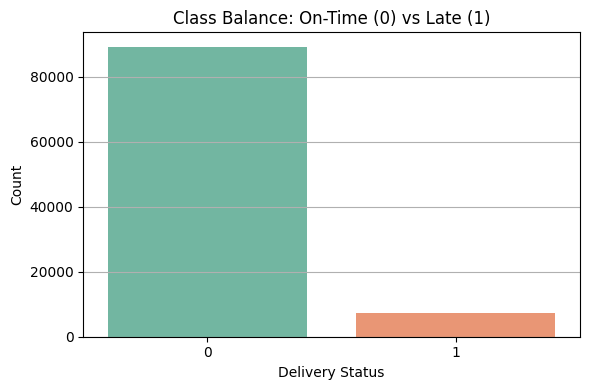


Class proportions:
late
0    89168
1     7308
late
0    92.43%
1     7.57%
Name: proportion, dtype: object


In [ ]:
# Compute day deltas (vectorized; safe on NaT)
orders["delivery_days"] = (
    orders["order_delivered_customer_date"] - orders["order_purchase_timestamp"]
).dt.days

orders["estimated_days"] = (
    orders["order_estimated_delivery_date"] - orders["order_purchase_timestamp"]
).dt.days

# Identify rows eligible for supervised labeling
has_delivery  = orders["delivery_days"].notna()
has_estimate  = orders["estimated_days"].notna()
eligible_mask = has_delivery & has_estimate

n_total      = len(orders)
n_eligible   = int(eligible_mask.sum())
n_ineligible = n_total - n_eligible

print(f"Total orders: {n_total}")
print(f"Eligible for labeling (have delivery & estimated): {n_eligible} ({n_eligible/n_total:.1%})")
print(f"Ineligible (missing one/both): {n_ineligible} ({n_ineligible/n_total:.1%})")

# Create labeled view (do not overwrite original 'orders')
orders_labeled = orders.loc[eligible_mask].copy()

# Label: late = 1 if actual > estimated; else 0
orders_labeled["late"] = (orders_labeled["delivery_days"] > orders_labeled["estimated_days"]).astype(int)

# Sanity checks on labeled data
assert orders_labeled["late"].isin([0, 1]).all(), "Late must be binary 0/1."
assert orders_labeled["delivery_days"].ge(0).all(), "Negative delivery_days found after prior QC."
assert orders_labeled["estimated_days"].ge(0).all(), "Negative estimated_days found after prior QC."

print("\n✅ Labeled dataset created: 'orders_labeled'")
display(orders_labeled[[
    "order_id", "order_purchase_timestamp",
    "order_delivered_customer_date", "order_estimated_delivery_date",
    "delivery_days", "estimated_days", "late"
]].head(5))

# Slide-ready class balance visual

plt.figure(figsize=(6,4))
sns.countplot(x="late", data=orders_labeled, palette="Set2")
plt.title("Class Balance: On-Time (0) vs Late (1)")
plt.xlabel("Delivery Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Also print proportions (defense: motivates metric choice later)
class_props = orders_labeled["late"].value_counts(normalize=True).rename({"0":"on_time","1":"late"})
print("\nClass proportions:")
print(orders_labeled["late"].value_counts().to_string())
print((orders_labeled["late"].value_counts(normalize=True)*100).round(2).astype(str) + "%")

# Keep a clean reference to use downstream (merges & FeatureTools later)
# We'll use 'orders_labeled' for joins in next steps to avoid confusion.


# Merge Orders with Items, Products, Customers, and Sellers
Goal:
    - Create an enriched, order-level dataset for feature engineering and modeling.

    - Merge strategy (defense-ready):

        -orders ↔ items on order_id (may be multiple items per order).

        -items ↔ products on product_id.

        -orders ↔ customers on customer_id.

        -items ↔ sellers on seller_id.

Aggregation:

Since we want one row per order (supervised classification), multiple items per order must be aggregated:

    -e.g., total price, total freight, number of items, number of distinct sellers/products.

This preserves the order-level late label.

Aggregated item-level features:


,order_id,total_price,total_freight,n_sellers,n_products,n_items,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,1,1,1,650.0,28.0,9.0,14.0
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,1,1,1,30000.0,50.0,30.0,40.0
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,1,1,1,3050.0,33.0,13.0,33.0
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,1,1,1,200.0,16.0,10.0,15.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,1,1,1,3750.0,35.0,40.0,30.0



✅ Orders enriched with items, products, sellers, customers.
Shape: (96476, 25)
Columns: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'order_purchase_year', 'delivery_days', 'estimated_days', 'late', 'total_price', 'total_freight', 'n_sellers', 'n_products', 'n_items', 'product_weight_g', 'product_length_cm', 'product_height_cm'] ...

Missingness in top 15 columns (percent):


,missing_pct
order_delivered_carrier_date,0.195904
product_width_cm,0.016584
product_length_cm,0.016584
product_height_cm,0.016584
order_approved_at,0.014511
order_purchase_timestamp,0.000000
order_id,0.000000
order_status,0.000000
customer_id,0.000000
order_purchase_year,0.000000


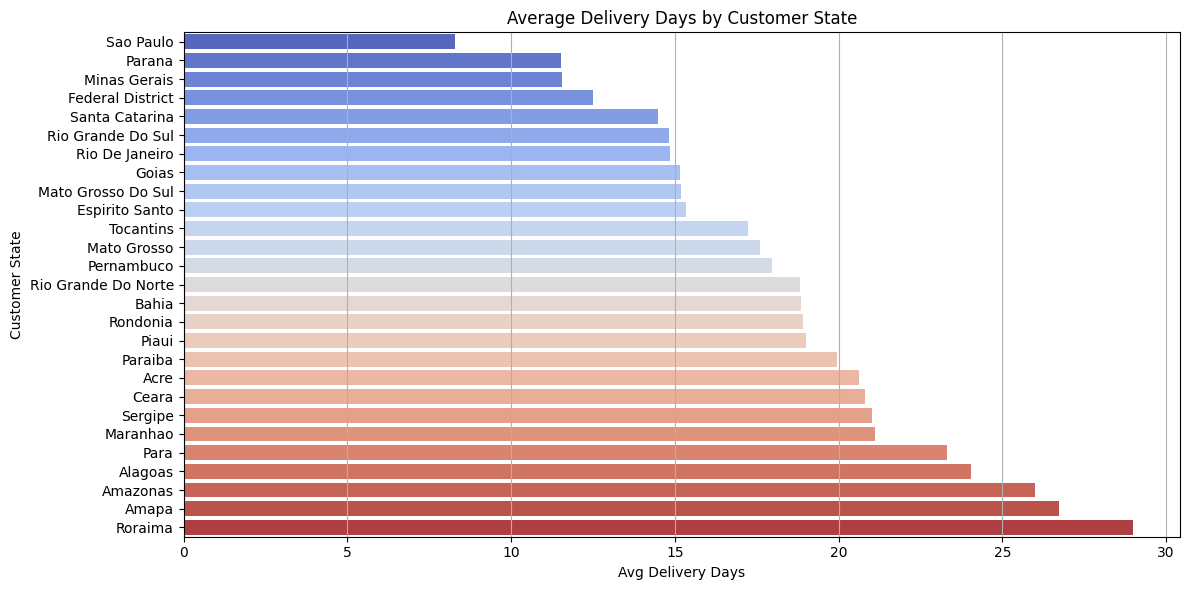

In [ ]:
# Standardize headers (idempotent; safe to re-run)
items     = standardize_headers(items)
customers = standardize_headers(customers)
sellers   = standardize_headers(sellers)

# Join items ↔ products (enrich with category + dimensions)
items_products = items.merge(
    products,
    how="left",
    on="product_id",
    validate="m:1"  # each item maps to exactly one product
)

# Join items_products ↔ sellers (enrich with seller state/city)
items_products_sellers = items_products.merge(
    sellers,
    how="left",
    on="seller_id",
    validate="m:1"  # each item has one seller
)

# Aggregate items → order level (collapse to 1 row per order_id)
agg_funcs = {
    "price": "sum",
    "freight_value": "sum",
    "seller_id": pd.Series.nunique,
    "product_id": pd.Series.nunique,
    "order_item_id": "count",
    "product_weight_g": "sum",
    "product_length_cm": "mean",
    "product_height_cm": "mean",
    "product_width_cm": "mean"
}

items_agg = items_products_sellers.groupby("order_id").agg(agg_funcs).reset_index()
items_agg.rename(columns={
    "seller_id": "n_sellers",
    "product_id": "n_products",
    "order_item_id": "n_items",
    "price": "total_price",
    "freight_value": "total_freight"
}, inplace=True)

print("Aggregated item-level features:")
display(items_agg.head(5))

# Merge orders_labeled ↔ items_agg
orders_items = orders_labeled.merge(
    items_agg,
    how="left",
    on="order_id",
    validate="1:1"  # 1 order → 1 aggregated item row
)

# Merge customers
orders_customers = orders_items.merge(
    customers,
    how="left",
    on="customer_id",
    validate="m:1"  # each order has one customer
)

# Merge final enriched DataFrame
orders_enriched = orders_customers.copy()

print("\n✅ Orders enriched with items, products, sellers, customers.")
print("Shape:", orders_enriched.shape)
print("Columns:", orders_enriched.columns.tolist()[:20], "...")

# Basic NA diagnostics
na_summary = (
    orders_enriched.isna().mean().sort_values(ascending=False).head(15) * 100
).to_frame("missing_pct")
print("\nMissingness in top 15 columns (percent):")
display(na_summary)

# Slide-ready sanity check visual: Avg delivery days by customer state
plt.figure(figsize=(12,6))
sns.barplot(
    x="delivery_days",
    y="customer_state",
    data=orders_enriched.groupby("customer_state", as_index=False)["delivery_days"].mean().sort_values("delivery_days"),
    palette="coolwarm"
)
plt.title("Average Delivery Days by Customer State")
plt.xlabel("Avg Delivery Days")
plt.ylabel("Customer State")
plt.tight_layout()
plt.show()


# Automated Feature Engineering with FeatureTools
Goals

    - Build a FeatureTools EntitySet with orders, items, products, customers, and sellers.

    - Run Deep Feature Synthesis (DFS) to automatically generate aggregated features:

    - Examples: total freight, average product size, number of distinct sellers.

    - Prune redundant/low-value features.

    - Keep everything at the order level (our prediction target).


In [28]:
import traceback, sys, gc

def step(msg):
    print(f"\n=== 6C:: {msg} ===")

try:
    step("A) Inputs & normalization")
    # --- paste the Step 6C (FINAL, Leak-Proof) cell HERE, BUT:
    # 1) wrap each major section with step("...") calls
    # 2) keep the same variable names (orders_ft, items_ft, es, X_timeaware, y)

    # ---------- A) Robust input coercion & header normalization ----------
    step("A.1 Ensure DataFrames / read CSV if paths")
    import numpy as np, pandas as pd
    import featuretools as ft
    from pathlib import Path
    from featuretools.selection import remove_low_information_features

    def ensure_dataframe(name, obj):
        if isinstance(obj, pd.DataFrame): return obj.copy()
        if isinstance(obj, (str, Path)):
            p = Path(obj); assert p.exists(), f"'{name}' path does not exist: {p}"
            return pd.read_csv(p)
        if hasattr(obj, "to_pandas"): return obj.to_pandas()
        raise TypeError(f"'{name}' must be DataFrame or CSV path. Got {type(obj)}")

    def standardize_headers(df):
        df = df.copy()
        df.columns = (df.columns.str.strip().str.lower().str.replace(" ", "_", regex=False))
        return df

    def parse_dates(df, cols):
        df = df.copy()
        for c in cols:
            if c in df.columns:
                df[c] = pd.to_datetime(df[c], errors="coerce")
        return df

    required = ["orders_enriched","orders","items","products","customers","sellers"]
    missing = [n for n in required if n not in globals()]
    assert not missing, f"Missing required inputs: {missing}"

    for name in required:
        globals()[name] = standardize_headers(ensure_dataframe(name, globals()[name]))

    print("Inputs standardized:")
    for name in required:
        df = globals()[name]
        print(f"  - {name}: shape={df.shape}, dtypes={dict(df.dtypes.astype(str).head())}")

    # ---------- B) Ensure purchase timestamp & target ----------
    step("B) Purchase timestamp & target checks")
    if "order_purchase_timestamp" not in orders_enriched.columns:
        assert {"order_id","order_purchase_timestamp"}.issubset(orders.columns), \
            "'orders' must include order_id & order_purchase_timestamp."
        orders_enriched = orders_enriched.merge(
            orders[["order_id","order_purchase_timestamp"]],
            on="order_id", how="left", validate="1:1"
        )
    orders_enriched = parse_dates(orders_enriched, ["order_purchase_timestamp"])
    assert "late" in orders_enriched.columns, "Target 'late' missing."
    assert orders_enriched["order_id"].is_unique, "orders_enriched must be 1 row per order_id."

    # ---------- C) Build FT base frames (label stripped BEFORE DFS) ----------
    step("C) Build base frames & remove label before DFS")
    orders_ft = orders_enriched[["order_id","customer_id","order_purchase_timestamp","late"]].copy()
    orders_ft_nolabel = orders_ft.drop(columns=["late"], errors="ignore").copy()

    for fk in ["order_id","product_id","seller_id"]:
        assert fk in items.columns, f"'items' missing FK column: {fk}"
    items_ft = items.copy().reset_index(drop=True)
    if "items_idx" not in items_ft.columns:
        items_ft["items_idx"] = np.arange(len(items_ft), dtype=np.int64)
    for tcol in ["shipping_limit_date","created_at","updated_at","estimated_shipping_date"]:
        if tcol in items_ft.columns:
            items_ft[tcol] = pd.to_datetime(items_ft[tcol], errors="coerce")

    products_ft  = products.drop_duplicates(subset=["product_id"]).copy()
    customers_ft = customers.drop_duplicates(subset=["customer_id"]).copy()
    sellers_ft   = sellers.drop_duplicates(subset=["seller_id"]).copy()
    assert products_ft["product_id"].is_unique,  "products_ft.product_id not unique"
    assert customers_ft["customer_id"].is_unique,"customers_ft.customer_id not unique"
    assert sellers_ft["seller_id"].is_unique,    "sellers_ft.seller_id not unique"

    # ---------- D) EntitySet ----------
    step("D) EntitySet + add dataframes")
    es = ft.EntitySet(id="olist_timeaware_final")
    es = es.add_dataframe(dataframe_name="orders",   dataframe=orders_ft_nolabel,
                          index="order_id", time_index="order_purchase_timestamp")
    es = es.add_dataframe(dataframe_name="items",    dataframe=items_ft,    index="items_idx")
    es = es.add_dataframe(dataframe_name="products", dataframe=products_ft, index="product_id")
    es = es.add_dataframe(dataframe_name="customers",dataframe=customers_ft,index="customer_id")
    es = es.add_dataframe(dataframe_name="sellers",  dataframe=sellers_ft,  index="seller_id")

    step("D.1) Relationships")
    assert "order_id" in items_ft.columns and "product_id" in items_ft.columns and "seller_id" in items_ft.columns
    assert "customer_id" in orders_ft_nolabel.columns
    es = es.add_relationship("orders",   "order_id",    "items",     "order_id")
    es = es.add_relationship("products", "product_id",  "items",     "product_id")
    es = es.add_relationship("customers","customer_id", "orders",    "customer_id")
    es = es.add_relationship("sellers",  "seller_id",   "items",     "seller_id")

    # ---------- E) Cutoff ----------
    step("E) Cutoff table")
    cutoff_df = orders_ft_nolabel[["order_id","order_purchase_timestamp"]].rename(
        columns={"order_purchase_timestamp":"time"}
    )
    assert cutoff_df["time"].notna().all(), "NaT in cutoff times."

    # ---------- F) Speed profile ----------
    step("F) DFS params")
    SPEED_PROFILE = "balanced"  # change to "dev" if debugging
    if SPEED_PROFILE == "dev":
        MAX_DEPTH = 1; AGG = ["mean","sum","count","num_unique"]; TRANS = ["month","weekday"]; TRAINING_WINDOW = "180d"; APPROX = "14d"
    elif SPEED_PROFILE == "balanced":
        MAX_DEPTH = 2; AGG = ["mean","sum","count","num_unique","mode"]; TRANS = ["month","weekday","day","is_weekend"]; TRAINING_WINDOW = "365d"; APPROX = "7d"
    else:
        MAX_DEPTH = 2; AGG = ["mean","sum","count","num_unique","mode"]; TRANS = ["month","weekday","day","is_weekend"]; TRAINING_WINDOW = None; APPROX = None

    dfs_kwargs = dict(
        entityset=es, target_dataframe_name="orders",
        agg_primitives=AGG, trans_primitives=TRANS, max_depth=MAX_DEPTH,
        cutoff_time=cutoff_df, cutoff_time_in_index=True, verbose=True
    )
    if TRAINING_WINDOW: dfs_kwargs["training_window"] = TRAINING_WINDOW
    if APPROX: dfs_kwargs["approximate"] = APPROX

    # ---------- G) DFS ----------
    step("G) Run DFS (this is the heavy step)")
    feature_matrix_taware, feature_defs_taware = ft.dfs(**dfs_kwargs)
    if "late" in feature_matrix_taware.columns:
        feature_matrix_taware = feature_matrix_taware.drop(columns=["late"])

    # ---------- H) Low-info pruning (version-safe) ----------
    step("H) Low-info prune")
    _res = remove_low_information_features(feature_matrix_taware)
    if isinstance(_res, tuple):
        feature_matrix_taware_pruned, kept_feats = _res
    else:
        feature_matrix_taware_pruned, kept_feats = _res, None

   # ---------- I) Sanitize & align target ----------
    step("I) Sanitize numerics & align y")
    X_timeaware = feature_matrix_taware_pruned.select_dtypes(include=[np.number]).copy()
    X_timeaware = X_timeaware.replace([np.inf, -np.inf], np.nan).fillna(0.0).astype("float32")

    # FIX: Handle MultiIndex from cutoff_time_in_index=True
    if isinstance(X_timeaware.index, pd.MultiIndex):
        # Extract order_id from MultiIndex (level 0)
        order_ids = X_timeaware.index.get_level_values(0)
        y = orders_ft.set_index("order_id").loc[order_ids, "late"].astype(int)
        y.index = X_timeaware.index  # Restore MultiIndex to match X
    else:
        # Simple index case
        y = orders_ft.set_index("order_id").loc[X_timeaware.index, "late"].astype(int)

    assert X_timeaware.shape[0] == y.shape[0] and X_timeaware.shape[0] > 0
    assert set(np.unique(y)).issubset({0,1})

    print("\n✅ Leak-free, time-aware features built.")
    print("Shapes → X_timeaware:", X_timeaware.shape, "| y:", y.shape)
    print("Sample features:", list(X_timeaware.columns[:10]))

except Exception as e:
    print("\n❌ 6C FAILED")
    print("Error:", repr(e))
    traceback.print_exc(limit=3, file=sys.stdout)
    # Minimal context dump for fast triage
    try:
        print("\n[Context] orders_ft_nolabel.head():"); display(orders_ft_nolabel.head(3))
    except: pass
    try:
        print("\n[Context] items_ft.head():"); display(items_ft.head(3))
    except: pass
    try:
        print("\n[Context] cutoff_df.head():"); display(cutoff_df.head(3))
    except: pass
    gc.collect()
    raise


=== 6C:: A) Inputs & normalization ===

=== 6C:: A.1 Ensure DataFrames / read CSV if paths ===
Inputs standardized:
  - orders_enriched: shape=(96476, 25), dtypes={'order_id': 'object', 'customer_id': 'object', 'order_status': 'object', 'order_purchase_timestamp': 'datetime64[ns]', 'order_approved_at': 'datetime64[ns]'}
  - orders: shape=(99441, 11), dtypes={'order_id': 'object', 'customer_id': 'object', 'order_status': 'object', 'order_purchase_timestamp': 'datetime64[ns]', 'order_approved_at': 'datetime64[ns]'}
  - items: shape=(112650, 7), dtypes={'order_id': 'object', 'order_item_id': 'int64', 'product_id': 'object', 'seller_id': 'object', 'shipping_limit_date': 'object'}
  - products: shape=(32951, 9), dtypes={'product_id': 'object', 'product_category_name': 'object', 'product_name_lenght': 'float64', 'product_description_lenght': 'float64', 'product_photos_qty': 'float64'}
  - customers: shape=(99441, 5), dtypes={'customer_id': 'object', 'customer_unique_id': 'object', 'customer

In [29]:
# Run this ONLY after the wrapper succeeds.
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X_tr, X_te, y_tr, y_te = train_test_split(X_timeaware, y, test_size=0.2, stratify=y, random_state=42)
stump = DecisionTreeClassifier(max_depth=1, random_state=42).fit(X_tr, y_tr)
auc = roc_auc_score(y_te, stump.predict_proba(X_te)[:,1])
print("1-depth stump AUC (should be < 1.0):", round(auc, 3))

1-depth stump AUC (should be < 1.0): 0.567


# Inspect Engineered Features

In [30]:
# Helper to pick first available feature by primitive keyword
def pick_feature_by_keyword(columns, keyword):
    return next((c for c in columns if keyword.upper() in c.upper()), None)

mean_feat = pick_feature_by_keyword(feature_matrix_taware_pruned.columns, "MEAN")
sum_feat  = pick_feature_by_keyword(feature_matrix_taware_pruned.columns, "SUM")
count_feat= pick_feature_by_keyword(feature_matrix_taware_pruned.columns, "COUNT")
unique_feat=pick_feature_by_keyword(feature_matrix_taware_pruned.columns, "NUM_UNIQUE")
mode_feat = pick_feature_by_keyword(feature_matrix_taware_pruned.columns, "MODE")

representative_features_real = {
    "Mean": mean_feat,
    "Sum": sum_feat,
    "Count": count_feat,
    "Num Unique": unique_feat,
    "Mode": mode_feat
}

print("Representative engineered features (one per primitive type):")
for k, v in representative_features_real.items():
    print(f"- {k}: {v}")

# Provide example interpretations (generic templates you can adapt)
print("\nInterpretations:")
if mean_feat:
    print(f"- {mean_feat}: Average value (proxy for order-level averages, e.g., price or dimension).")
if sum_feat:
    print(f"- {sum_feat}: Total value (proxy for overall magnitude, e.g., freight or weight).")
if count_feat:
    print(f"- {count_feat}: Count of related entities (proxy for order complexity/size).")
if unique_feat:
    print(f"- {unique_feat}: Number of distinct entities (proxy for diversity, e.g., sellers/products).")
if mode_feat:
    print(f"- {mode_feat}: Most common categorical value (proxy for dominant product type).")

Representative engineered features (one per primitive type):
- Mean: MEAN(items.freight_value)
- Sum: SUM(items.freight_value)
- Count: COUNT(items)
- Num Unique: NUM_UNIQUE(items.DAY(shipping_limit_date))
- Mode: MODE(items.DAY(shipping_limit_date))

Interpretations:
- MEAN(items.freight_value): Average value (proxy for order-level averages, e.g., price or dimension).
- SUM(items.freight_value): Total value (proxy for overall magnitude, e.g., freight or weight).
- COUNT(items): Count of related entities (proxy for order complexity/size).
- NUM_UNIQUE(items.DAY(shipping_limit_date)): Number of distinct entities (proxy for diversity, e.g., sellers/products).
- MODE(items.DAY(shipping_limit_date)): Most common categorical value (proxy for dominant product type).


# Model Lineup, Split, and Tuning Spaces
Models (5 total):

 -Logistic Regression (baseline, scaled)

 -Decision Tree (nonlinear baseline)

 -Random Forest (bagging ensemble)

 -XGBoost (boosting ensemble)

 -CatBoost (boosting, categorical-native)


In [32]:

X = X_timeaware.copy()
y = y.copy()

# FIX: Reset MultiIndex to avoid complications with train_test_split
if isinstance(X.index, pd.MultiIndex):
    print("Resetting MultiIndex for clean train/test split...")
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print("Shapes →", "X_train:", X_train.shape, "| X_test:", X_test.shape)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = "roc_auc"
N_ITER = 12

pos_ratio = (y_train == 0).sum() / max((y_train == 1).sum(), 1)

logreg_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42))
])

param_spaces = {
    "Logistic Regression": {
        "model": logreg_pipe,
        "params": {"clf__C": np.logspace(-3,3,10), "clf__penalty": ["l2"]},
        "n_iter": N_ITER
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [3,5,7,9,None],
            "min_samples_split": [2,5,10],
            "min_samples_leaf": [1,2,5],
            "class_weight": [None,"balanced"]
        },
        "n_iter": N_ITER
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, n_jobs=-1),
        "params": {
            "n_estimators": [200,400,600],
            "max_depth": [None,10,20],
            "min_samples_leaf": [1,2,5],
            "max_features": ["sqrt","log2"],
            "class_weight": [None,"balanced_subsample"]
        },
        "n_iter": N_ITER
    },
    "XGBoost": {
        "model": xgb.XGBClassifier(
            objective="binary:logistic", random_state=42, n_jobs=-1,
            eval_metric="auc", tree_method="hist", use_label_encoder=False,
            scale_pos_weight=pos_ratio
        ),
        "params": {
            "n_estimators": [300,600,900],
            "max_depth": [3,5,7],
            "learning_rate": [0.03,0.1,0.2],
            "subsample": [0.8,1.0],
            "colsample_bytree": [0.8,1.0],
            "reg_lambda": [0,5,10]
        },
        "n_iter": N_ITER
    },
    "CatBoost": {
        "model": CatBoostClassifier(
            loss_function="Logloss", random_seed=42, verbose=False, thread_count=-1
        ),
        "params": {
            "iterations": [400,800,1200],
            "depth": [4,6,8],
            "learning_rate": [0.03,0.1],
            "l2_leaf_reg": [3,5,10],
            "subsample": [0.8,1.0],
            "rsm": [0.8,1.0]
        },
        "n_iter": N_ITER
    }
}



Resetting MultiIndex for clean train/test split...
Shapes → X_train: (77180, 38) | X_test: (19296, 38)


# Hyperparameter Tuning & CV Leaderboard
Goal: Use RandomizedSearchCV (5-fold Stratified CV, scoring = ROC AUC) to find strong configurations for:

    -Logistic Regression (scaled), Decision Tree, Random Forest, XGBoost, CatBoost.

Outputs:

    -best_models — dict of tuned estimators keyed by model name.

    -cv_summary_df — table with CV best AUC, fit time, and best params

In [33]:
# ============================================================
# Step 7B — RandomizedSearchCV for each model + CV leaderboard
# ============================================================

import time
from sklearn.model_selection import RandomizedSearchCV

best_models = {}
cv_rows = []

for name, cfg in param_spaces.items():
    print(f"\n🔎 Tuning {name} ...")
    start = time.perf_counter()
    rs = RandomizedSearchCV(
        estimator=cfg["model"],
        param_distributions=cfg["params"],
        n_iter=cfg.get("n_iter", 12),
        scoring=scoring, cv=cv, random_state=42, verbose=0, n_jobs=-1
    )
    rs.fit(X_train, y_train)
    elapsed = time.perf_counter() - start
    best_models[name] = rs.best_estimator_
    cv_rows.append({
        "Model": name,
        "CV Best AUC": rs.best_score_,
        "Fit Time (s)": round(elapsed, 2),
        "Best Params": rs.best_params_
    })
    print(f"→ Best AUC: {rs.best_score_:.4f} | Time: {elapsed:.2f}s")

cv_summary_df = pd.DataFrame(cv_rows).sort_values("CV Best AUC", ascending=False).reset_index(drop=True)
print("\n✅ CV Tuning Summary:")
display(cv_summary_df)


🔎 Tuning Logistic Regression ...
→ Best AUC: 0.5776 | Time: 5.47s

🔎 Tuning Decision Tree ...
→ Best AUC: 0.6385 | Time: 2.71s

🔎 Tuning Random Forest ...
→ Best AUC: 0.6587 | Time: 109.96s

🔎 Tuning XGBoost ...
→ Best AUC: 0.6804 | Time: 14.10s

🔎 Tuning CatBoost ...
→ Best AUC: 0.6766 | Time: 267.73s

✅ CV Tuning Summary:


,Model,CV Best AUC,Fit Time (s),Best Params
0,XGBoost,0.680384,14.10,"{'subsample': 0.8, 'reg_lambda': 10, 'n_estima..."
1,CatBoost,0.676588,267.73,"{'subsample': 0.8, 'rsm': 1.0, 'learning_rate'..."
2,Random Forest,0.658732,109.96,"{'n_estimators': 600, 'min_samples_leaf': 5, '..."
3,Decision Tree,0.638456,2.71,"{'min_samples_split': 5, 'min_samples_leaf': 2..."
4,Logistic Regression,0.577648,5.47,"{'clf__penalty': 'l2', 'clf__C': 0.001}"


# Full Test Evaluation + Confusion Matrices
Goal:

    - Use the tuned models (best_models)

    - Evaluate on the test set (never seen in training or CV).

    - Capture Accuracy, Precision, Recall, F1, AUC.

    - Plot Confusion Matrices.


🔎 Logistic Regression
Accuracy: 0.924
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
ROC AUC: 0.585


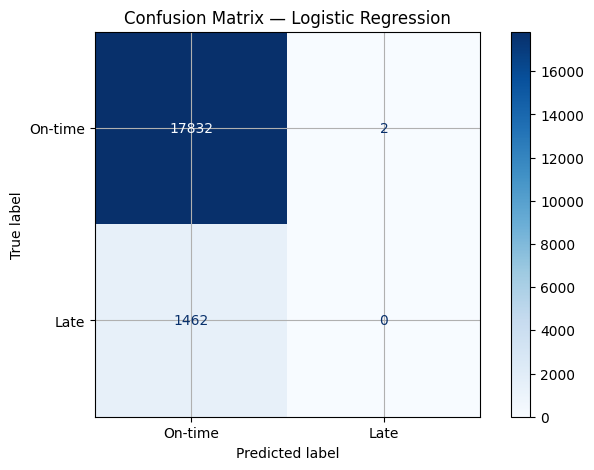


🔎 Decision Tree
Accuracy: 0.923
Precision: 0.080
Recall: 0.001
F1 Score: 0.003
ROC AUC: 0.641


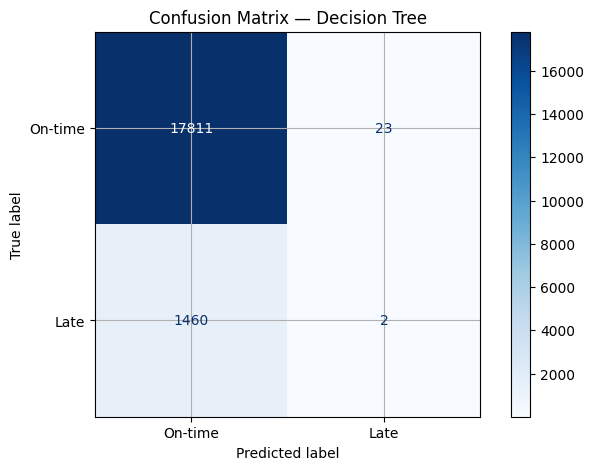


🔎 Random Forest
Accuracy: 0.900
Precision: 0.195
Recall: 0.101
F1 Score: 0.133
ROC AUC: 0.645


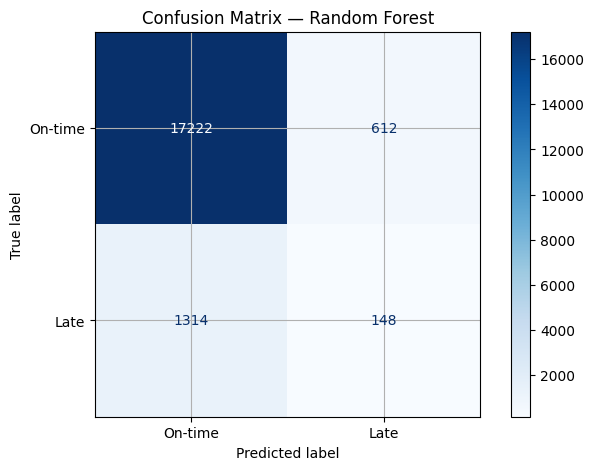


🔎 XGBoost
Accuracy: 0.708
Precision: 0.133
Recall: 0.520
F1 Score: 0.212
ROC AUC: 0.676


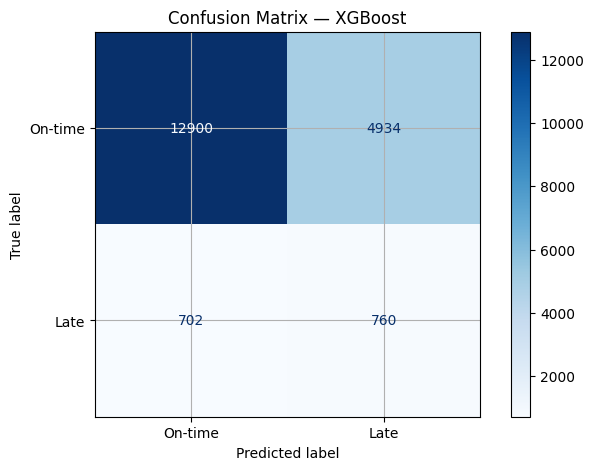


🔎 CatBoost
Accuracy: 0.924
Precision: 1.000
Recall: 0.001
F1 Score: 0.001
ROC AUC: 0.673


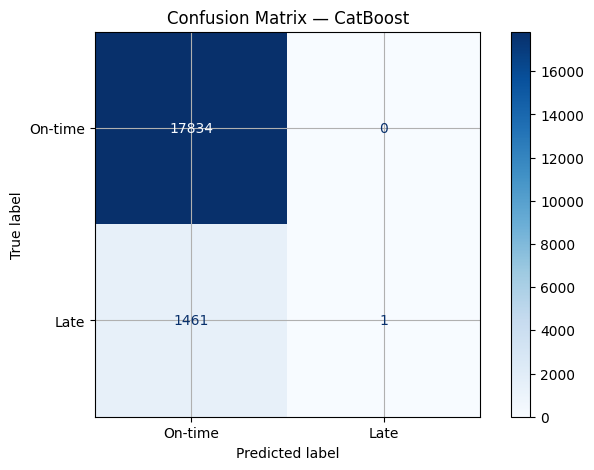


✅ Final Test Results:


,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
XGBoost,0.707919,0.133474,0.519836,0.212409,0.675737
CatBoost,0.924285,1.000000,0.000684,0.001367,0.672996
Random Forest,0.900187,0.194737,0.101231,0.133213,0.645137
Decision Tree,0.923145,0.080000,0.001368,0.002690,0.641000
Logistic Regression,0.924129,0.000000,0.000000,0.000000,0.584518


In [34]:
# ============================================================
# Step 7C — Evaluate tuned models on held-out test set
# ============================================================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

final_results = []

for name, model in best_models.items():
    # Models already fitted by RandomizedSearchCV with refit=True

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model,"predict_proba") else y_pred

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_test, y_proba)
    }
    final_results.append(metrics)

    print(f"\n🔎 {name}")
    for k,v in metrics.items():
        if k != "Model":
            print(f"{k}: {v:.3f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["On-time","Late"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix — {name}")
    plt.show()

final_results_df = pd.DataFrame(final_results).set_index("Model").sort_values("ROC AUC", ascending=False)
print("\n✅ Final Test Results:")
display(final_results_df)

# ROC & Precision–Recall Curves
Goal:

    - Plot ROC curves for all tuned models → shows probability ranking ability (AUC).

    - Plot Precision–Recall curves → more informative under class imbalance.

    - Helps defend threshold choices and visualize tradeoffs.

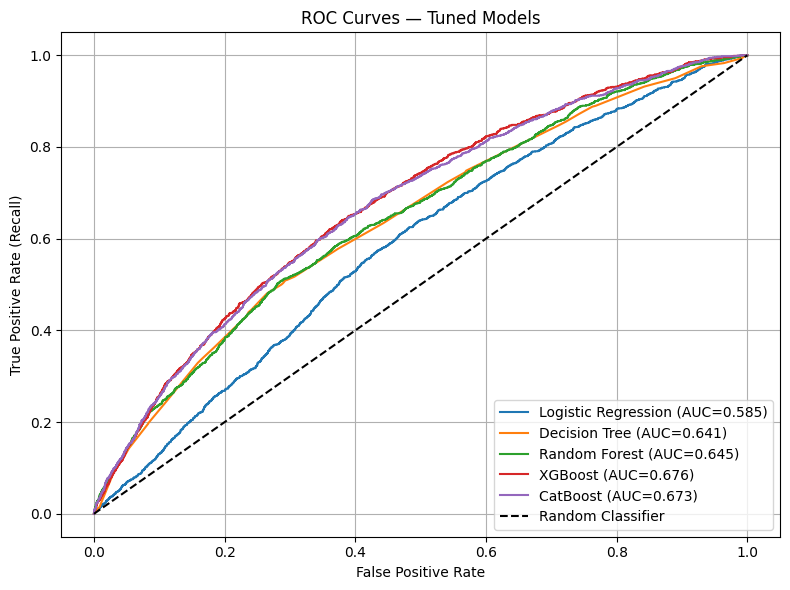

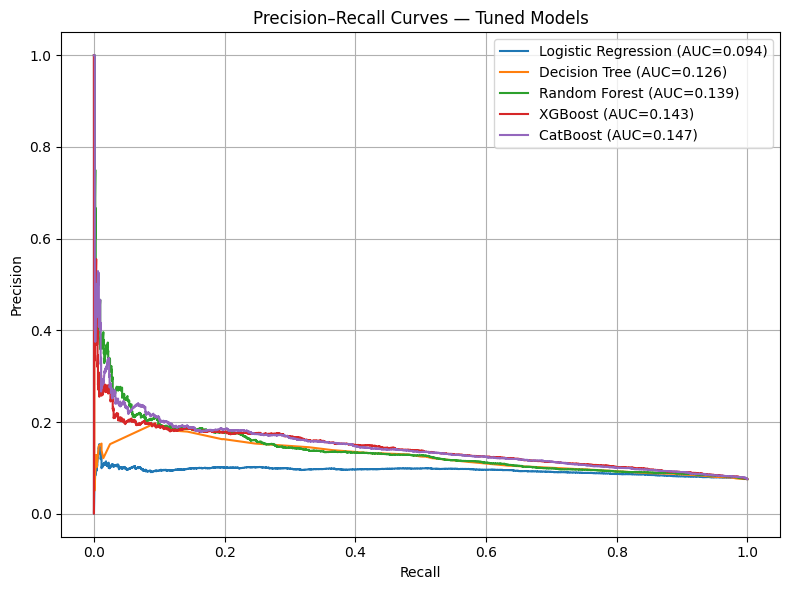

In [35]:
# ============================================================
# Step 7D — ROC & Precision-Recall Curves (slide-ready)
# ============================================================

from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# ROC Curves
plt.figure(figsize=(8,6))
for name, model in best_models.items():
    # Models already fitted by RandomizedSearchCV

    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0,1],[0,1],"k--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves — Tuned Models")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Precision-Recall Curves
plt.figure(figsize=(8,6))
for name, model in best_models.items():
    # Models already fitted by RandomizedSearchCV

    y_proba = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (AUC={pr_auc:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves — Tuned Models")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Winner Selection Logic & Artifact Save
Goal: Choose the final model in a defensible way when AUCs are close or identical.

  Selection rules (transparent & defense-ready):

    - Primary metric: Highest ROC AUC on the held-out test set.

    - Tie-breaker: Highest F1 Score at the operational threshold (0.5).

    - If still tied: Choose by deployment preference (industry support & practicality):
    XGBoost → CatBoost → Random Forest → Logistic Regression → Decision Tree.


In [36]:
# ============================================================
# Step 7E — Select winner (AUC → F1 tie-break) & save artifacts
# ============================================================

import os, json, joblib
from pathlib import Path

AUC_TOL = 1e-4
max_auc = final_results_df["ROC AUC"].max()
auc_ties = final_results_df[final_results_df["ROC AUC"] >= (max_auc - AUC_TOL)].copy()

if len(auc_ties) > 1:
    max_f1 = auc_ties["F1 Score"].max()
    f1_ties = auc_ties[auc_ties["F1 Score"] >= (max_f1 - 1e-6)].copy()
else:
    f1_ties = auc_ties

deploy_preference = ["XGBoost", "CatBoost", "Random Forest", "Logistic Regression", "Decision Tree"]
if len(f1_ties) > 1:
    ordered = sorted(f1_ties.index, key=lambda m: deploy_preference.index(m) if m in deploy_preference else 999)
    winner_name = ordered[0]
else:
    winner_name = f1_ties.index[0]

final_model_name = winner_name
final_model = best_models[final_model_name]
# Model already fitted by RandomizedSearchCV in Step 7B

winner_metrics = final_results_df.loc[final_model_name].to_dict()
print("🏆 Final Winner Selected")
print(f"Model: {final_model_name}")
print(f"ROC AUC: {winner_metrics['ROC AUC']:.4f} | F1: {winner_metrics['F1 Score']:.4f} "
      f"| Precision: {winner_metrics['Precision']:.4f} | Recall: {winner_metrics['Recall']:.4f} "
      f"| Accuracy: {winner_metrics['Accuracy']:.4f}")

if len(auc_ties) > 1:
    print(f"\nNote: Multiple models tied on AUC within ±{AUC_TOL}.")
    if len(f1_ties) > 1:
        print(f"Tie persisted on F1; selected by deployment preference: {deploy_preference}.")
        print("Tied models after F1:", ", ".join(f1_ties.index.tolist()))
    else:
        print("Tie broken by higher F1.")

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(exist_ok=True, parents=True)

model_path  = ARTIFACTS_DIR / f"model_{final_model_name.replace(' ', '_').lower()}.pkl"
feats_path  = ARTIFACTS_DIR / "feature_names.json"
metrics_path= ARTIFACTS_DIR / f"metrics_{final_model_name.replace(' ', '_').lower()}.json"

joblib.dump(final_model, model_path)
with open(feats_path, "w") as f:
    json.dump(list(X_train.columns), f)
with open(metrics_path, "w") as f:
    json.dump({k: float(v) for k,v in winner_metrics.items()}, f, indent=2)

print("\n💾 Saved artifacts:")
print("Model  →", model_path)
print("Features →", feats_path)
print("Metrics  →", metrics_path)

final_metrics = winner_metrics  # exposed for next steps

print("\n✅ All done! 🎉")

🏆 Final Winner Selected
Model: XGBoost
ROC AUC: 0.6757 | F1: 0.2124 | Precision: 0.1335 | Recall: 0.5198 | Accuracy: 0.7079

💾 Saved artifacts:
Model  → artifacts/model_xgboost.pkl
Features → artifacts/feature_names.json
Metrics  → artifacts/metrics_xgboost.json

✅ All done! 🎉


# Model Explainability (SHAP + Fallbacks)

In [40]:
# Critical: permutation_importance
from sklearn.inspection import permutation_importance

# Optional imports with error handling
try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

try:
    from catboost import CatBoostClassifier
    HAS_CATBOOST = True
except ImportError:
    HAS_CATBOOST = False

# ---------- 8.0: Sanity ----------
assert 'final_model' in globals() and 'final_model_name' in globals(), "Run Step 7E to set final_model & name."
assert 'X_train' in globals() and 'X_test' in globals(), "Run Step 7A to define X splits."
ARTIFACTS = Path("artifacts")
ARTIFACTS.mkdir(exist_ok=True, parents=True)

model = final_model
model_name = final_model_name
feature_names = list(X_train.columns)

print(f"🔎 Explaining model: {model_name}")
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# ---------- 8.1: Helper — safe savefig ----------
def _savefig(path):
    plt.tight_layout()
    plt.savefig(path, dpi=180, bbox_inches="tight")
    plt.close()

# ---------- 8.2: Unwrap pipeline if needed ----------
def unwrap_model(m):
    """Extract the actual estimator from a Pipeline if wrapped."""
    if hasattr(m, "named_steps") and "clf" in m.named_steps:
        return m.named_steps["clf"]
    return m

base_model = unwrap_model(model)
print(f"Base model type: {type(base_model).__name__}")

# ---------- 8.3: Try SHAP (with robust selection of explainer) ----------
shap_available = False
try:
    import shap
    shap_available = True
    warnings.filterwarnings("ignore", category=UserWarning)
    print("✅ SHAP available")
except Exception as e:
    print(f"⚠️ SHAP not available; will use permutation_importance only. Error: {e}")

def is_tree(m):
    if HAS_XGB and isinstance(m, xgb.XGBClassifier):
        return True
    if HAS_CATBOOST and isinstance(m, CatBoostClassifier):
        return True
    return isinstance(m, (RandomForestClassifier, DecisionTreeClassifier))

def is_linear(m):
    return isinstance(m, LogisticRegression)

def is_catboost(m):
    return HAS_CATBOOST and isinstance(m, CatBoostClassifier)

# ---------- 8.4: Sampling to keep SHAP fast ----------
rng = np.random.RandomState(42)
bg_n = min(1000, len(X_train))
test_n = min(2000, len(X_test))
bg_idx = rng.choice(len(X_train), size=bg_n, replace=False)
ts_idx = rng.choice(len(X_test), size=test_n, replace=False)
X_bg = X_train.iloc[bg_idx].copy()
X_te_small = X_test.iloc[ts_idx].copy()
y_te_small = y_test.iloc[ts_idx].copy()

# Reset indices for clean referencing
X_bg = X_bg.reset_index(drop=True)
X_te_small = X_te_small.reset_index(drop=True)
y_te_small = y_te_small.reset_index(drop=True)

print(f"Sampled data: X_bg={X_bg.shape}, X_te_small={X_te_small.shape}")

# ---------- 8.5: Global importance — permutation (always compute) ----------
print("⏳ Computing permutation importance (global, model-agnostic)...")
perm = permutation_importance(model, X_te_small, y_te_small, n_repeats=10, random_state=42, n_jobs=-1)
pi_importance = pd.Series(perm.importances_mean, index=feature_names).sort_values(ascending=False)

# Plot permutation importance (bar, top 20)
topk = 20
plt.figure(figsize=(8, 6))
pi_importance.head(topk).iloc[::-1].plot(kind="barh")
plt.title(f"Global Importance (Permutation) — {model_name}")
plt.xlabel("Mean importance (test)")
_savefig(ARTIFACTS / "global_importance_permutation.png")
print("✅ Saved:", ARTIFACTS / "global_importance_permutation.png")

# ---------- 8.6: SHAP Global & Local (if available) ----------
top_features = list(pi_importance.head(3).index)
dependence_saved = []

if shap_available:
    try:
        # Choose explainer
        if is_tree(base_model):
            print("Using TreeExplainer...")

            if is_catboost(base_model):
                explainer = shap.TreeExplainer(base_model)
                shap_values = explainer.shap_values(X_te_small)
            else:
                explainer = shap.TreeExplainer(base_model)
                shap_values = explainer.shap_values(X_te_small)

            # For binary classifiers, TreeExplainer may return list [class0, class1]
            if isinstance(shap_values, list) and len(shap_values) == 2:
                shap_vals = shap_values[1]
            else:
                shap_vals = shap_values

        elif is_linear(base_model):
            print("Using LinearExplainer...")
            # For pipeline models, we need to transform X_bg first
            if hasattr(model, "named_steps") and "scaler" in model.named_steps:
                X_bg_scaled = model.named_steps["scaler"].transform(X_bg)
                X_te_scaled = model.named_steps["scaler"].transform(X_te_small)
                explainer = shap.LinearExplainer(base_model, X_bg_scaled)
                shap_vals = explainer.shap_values(X_te_scaled)
            else:
                explainer = shap.LinearExplainer(base_model, X_bg)
                shap_vals = explainer.shap_values(X_te_small)
        else:
            print("Using KernelExplainer (slower)...")
            explainer = shap.KernelExplainer(model.predict_proba, X_bg.iloc[:100])
            shap_vals = explainer.shap_values(X_te_small.iloc[:500])  # Limit for kernel
            X_te_small = X_te_small.iloc[:500]  # Match size

        # Ensure matrix shape is right
        shap_vals = np.array(shap_vals)
        if len(shap_vals.shape) == 1:
            shap_vals = shap_vals.reshape(-1, 1)
        assert shap_vals.shape[0] == X_te_small.shape[0], f"SHAP rows mismatch: {shap_vals.shape[0]} vs {X_te_small.shape[0]}"

        print(f"SHAP values computed: {shap_vals.shape}")

        # ----- Global: Beeswarm -----
        plt.figure(figsize=(8, 6))
        shap.summary_plot(shap_vals, X_te_small, show=False)
        _savefig(ARTIFACTS / "shap_summary_beeswarm.png")
        print("✅ Saved:", ARTIFACTS / "shap_summary_beeswarm.png")

        # ----- Global: Bar (mean |SHAP|) -----
        plt.figure(figsize=(8, 6))
        shap.summary_plot(shap_vals, X_te_small, plot_type="bar", show=False)
        _savefig(ARTIFACTS / "shap_summary_bar.png")
        print("✅ Saved:", ARTIFACTS / "shap_summary_bar.png")

        # ----- Dependence plots for top 3 permutation features -----
        for f in top_features:
            if f in X_te_small.columns:
                try:
                    plt.figure(figsize=(7, 5))
                    shap.dependence_plot(f, shap_vals, X_te_small, show=False)
                    safe_fname = f.replace(' ', '_').replace('/', '_').replace('.', '_').replace('(', '').replace(')', '')
                    outp = ARTIFACTS / f"shap_dependence_{safe_fname}.png"
                    _savefig(outp)
                    dependence_saved.append(outp)
                except Exception as e:
                    print(f"⚠️ Could not create dependence plot for {f}: {e}")
        if dependence_saved:
            print(f"✅ Saved {len(dependence_saved)} dependence plots")

        # ----- Local: explain 3 representative instances -----
        proba = model.predict_proba(X_te_small)[:, 1]
        order = np.argsort(proba)
        picks = [order[-1], order[len(order)//2], order[0]]

        for idx in picks:
            vals = shap_vals[idx]
            pred_proba = proba[idx]
            true_label = y_te_small.iloc[idx]

            print(f"\n--- Explaining Instance {idx} ---")
            print(f"Predicted Probability (Late): {pred_proba:.4f}")
            print(f"Actual Label: {'Late' if true_label == 1 else 'On-time'}")

            plt.figure(figsize=(8, 5))
            shap.waterfall_plot(shap.Explanation(
                values=vals,
                base_values=explainer.expected_value if not isinstance(explainer.expected_value, np.ndarray) else explainer.expected_value[1], # for binary
                data=X_te_small.iloc[idx],
                feature_names=list(X_te_small.columns)
            ), show=False)
            outp = ARTIFACTS / f"shap_waterfall_instance_{idx}.png"
            _savefig(outp)
            print("✅ Saved:", outp)

    except Exception as e:
        print(f"\n❌ SHAP failed: {repr(e)}")
        traceback.print_exc(limit=3, file=sys.stdout)

print("\n✅ Finished model explanation.")

🔎 Explaining model: XGBoost
X_train shape: (77180, 38), X_test shape: (19296, 38)
Base model type: XGBClassifier
✅ SHAP available
Sampled data: X_bg=(1000, 38), X_te_small=(2000, 38)
⏳ Computing permutation importance (global, model-agnostic)...
✅ Saved: artifacts/global_importance_permutation.png
Using TreeExplainer...
SHAP values computed: (2000, 38)
✅ Saved: artifacts/shap_summary_beeswarm.png
✅ Saved: artifacts/shap_summary_bar.png
✅ Saved 3 dependence plots

--- Explaining Instance 1879 ---
Predicted Probability (Late): 0.8848
Actual Label: Late
✅ Saved: artifacts/shap_waterfall_instance_1879.png

--- Explaining Instance 689 ---
Predicted Probability (Late): 0.3912
Actual Label: On-time
✅ Saved: artifacts/shap_waterfall_instance_689.png

--- Explaining Instance 1338 ---
Predicted Probability (Late): 0.0141
Actual Label: On-time
✅ Saved: artifacts/shap_waterfall_instance_1338.png

✅ Finished model explanation.


<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

In [41]:
# ----------------------- Config -----------------------------
st.set_page_config(
    page_title="Supply-Chain Delay Predictor",
    page_icon="📦",
    layout="wide"
)

ARTIFACTS = Path("artifacts")
FEATURES_JSON = ARTIFACTS / "feature_names.json"
GLOBAL_PI_PNG = ARTIFACTS / "global_importance_permutation.png"
SHAP_SUMMARY_BEE = ARTIFACTS / "shap_summary_beeswarm.png"
SHAP_SUMMARY_BAR = ARTIFACTS / "shap_summary_bar.png"

# -------------------- Helper Functions ----------------------
def unwrap_model(m):
    """Extract the actual estimator from a Pipeline if wrapped."""
    if hasattr(m, "named_steps") and "clf" in m.named_steps:
        return m.named_steps["clf"]
    return m

# -------------------- Cached loaders ------------------------
@st.cache_resource(show_spinner=False)
def load_model_and_features():
    """Load the trained model and feature schema from artifacts."""
    assert ARTIFACTS.exists(), "artifacts/ directory not found. Run Step 7E first."

    # Find model file
    candidates = sorted(ARTIFACTS.glob("model_*.pkl"))
    assert candidates, "No model_*.pkl found in artifacts/. Run Step 7E to save the model."
    model_path = candidates[0]

    # Load model
    model = joblib.load(model_path)

    # Load features
    assert FEATURES_JSON.exists(), "feature_names.json not found in artifacts/. Run Step 7E first."
    with open(FEATURES_JSON, "r") as f:
        features = json.load(f)

    # Get base model for introspection
    base_model = unwrap_model(model)

    return model, base_model, model_path.name, features

@st.cache_data(show_spinner=False)
def align_features(df: pd.DataFrame, features: list) -> pd.DataFrame:
    """Align input DataFrame to training feature schema."""
    df = df.copy()

    # Add missing expected columns
    for col in features:
        if col not in df.columns:
            df[col] = 0.0

    # Keep only expected features, in correct order
    df = df[features]

    # Sanitize: handle inf, nan
    df = df.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    # Ensure numeric types
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0.0)

    df = df.astype("float32")
    return df

def predict_batch(model, df_input: pd.DataFrame, features: list, threshold: float = 0.5):
    """Make predictions on a batch of records."""
    X = align_features(df_input, features)

    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)[:, 1]
    else:
        # Fallback: decision_function or predict
        if hasattr(model, "decision_function"):
            raw = model.decision_function(X)
        else:
            raw = model.predict(X)
        raw = np.asarray(raw, dtype="float32")
        # Normalize to [0,1]
        proba = (raw - raw.min()) / (raw.max() - raw.min() + 1e-9)

    pred = (proba >= threshold).astype(int)
    return proba, pred

# ----------------------- Sidebar ----------------------------
st.sidebar.header("⚙️ Settings")
threshold = st.sidebar.slider(
    "Decision Threshold (Late if ≥ threshold)",
    0.05, 0.95, 0.50, 0.01,
    help="Higher threshold = fewer false alarms but may miss some late orders"
)
show_importance = st.sidebar.checkbox("Show Feature Importance", value=True)
try_shap = st.sidebar.checkbox("Try SHAP on uploaded sample (requires shap package)", value=False)

st.sidebar.markdown("---")
st.sidebar.caption("💡 **Tip:** Model & features are loaded from `artifacts/` directory.")
st.sidebar.caption("📊 Run Steps 7E and 8 in your notebook to generate all artifacts.")

# ----------------------- Header -----------------------------
st.title("📦 Supply-Chain Delay Predictor")
st.caption("Binary classifier to flag potential delivery delays at order time — production ready.")

# -------------------- Load artifacts ------------------------
try:
    model, base_model, model_name, TRAIN_FEATURES = load_model_and_features()
    st.success(f"✅ Loaded model: **{model_name}** | Features: **{len(TRAIN_FEATURES)}**")

    # Show model type
    model_type = type(base_model).__name__
    st.info(f"🤖 Model type: **{model_type}**")

except Exception as e:
    st.error(f"❌ Failed to load artifacts: {e}")
    st.error("Make sure you've run Step 7E to save the model and Step 8 for explainability artifacts.")
    st.stop()

# -------------------- Tabs layout ---------------------------
tab_pred, tab_single, tab_explain = st.tabs([
    "📊 Batch Predict (CSV)",
    "📝 Single Record Form",
    "🔍 Explainability"
])

# ===================== Batch Predict Tab ====================
with tab_pred:
    st.subheader("Batch Predict from CSV")
    st.write(
        "Upload a CSV with **order-level** rows. Columns not in the training schema will be "
        "ignored; missing columns are filled with 0.0."
    )

    uploaded = st.file_uploader("Upload CSV", type=["csv"], key="batch_upload")

    with st.expander("ℹ️ What columns do I need?"):
        st.write(
            "At minimum, you can upload a CSV with just an ID column and we'll fill zeros for "
            "all features, but predictions will be uninformative. Best results come from using "
            "the same features used in training."
        )
        st.write(f"**Training features ({len(TRAIN_FEATURES)}):**")
        st.code(", ".join(TRAIN_FEATURES[:10]) + ("..." if len(TRAIN_FEATURES) > 10 else ""))

        # Show example
        example_df = pd.DataFrame([{TRAIN_FEATURES[i]: 0.0 for i in range(min(3, len(TRAIN_FEATURES)))}])
        st.code(example_df.to_csv(index=False), language="csv")

    if uploaded is not None:
        try:
            df_in = pd.read_csv(uploaded)

            # Validation
            if len(df_in) == 0:
                st.warning("⚠️ Uploaded CSV is empty!")
                st.stop()

            st.write(f"**Preview of uploaded data** ({len(df_in)} rows):")
            st.dataframe(df_in.head(10), use_container_width=True)

            # Predict
            with st.spinner("Making predictions..."):
                proba, pred = predict_batch(model, df_in, TRAIN_FEATURES, threshold)

            # Add results to output
            out = df_in.copy()
            out["late_probability"] = proba.round(4)
            out["late_pred"] = pred
            out["late_pred_label"] = out["late_pred"].map({0: "On-time", 1: "Late"})

            # Summary stats
            col1, col2, col3 = st.columns(3)
            col1.metric("Total Predictions", len(out))
            col2.metric("Predicted Late", (pred == 1).sum())
            col3.metric("Predicted On-time", (pred == 0).sum())

            st.success(f"✅ Predictions complete (threshold = {threshold:.2f})")

            # Show results
            st.write("**Results:**")
            st.dataframe(out.head(50), use_container_width=True)

            # Download button
            csv = out.to_csv(index=False).encode("utf-8")
            st.download_button(
                "📥 Download Predictions CSV",
                data=csv,
                file_name="predictions.csv",
                mime="text/csv",
                use_container_width=True
            )

        except Exception as e:
            st.error(f"❌ Error during prediction: {e}")
            import traceback
            with st.expander("Show error details"):
                st.code(traceback.format_exc())

# ===================== Single Record Tab ====================
with tab_single:
    st.subheader("Single Record (Manual Entry)")
    st.write("Provide values for key features. Any omitted features will default to 0.0.")

    # Show top N features in form
    N_TOP = min(12, len(TRAIN_FEATURES))

    with st.form(key="single_form"):
        st.write(f"**Enter values for top {N_TOP} features:**")
        cols = st.columns(2)
        inputs = {}

        for i, feat in enumerate(TRAIN_FEATURES[:N_TOP]):
            col = cols[i % 2]
            inputs[feat] = col.number_input(
                feat,
                value=0.0,
                step=0.1,
                format="%.4f",
                help=f"Feature {i+1} of {len(TRAIN_FEATURES)}"
            )

        st.markdown("---")
        st.write("**Optional: JSON Override**")
        st.caption("Provide a JSON object to override or add any feature values.")

        example_json = {TRAIN_FEATURES[0]: 1.2, TRAIN_FEATURES[1]: 0.3}
        raw_json = st.text_area(
            "JSON input (optional)",
            value="",
            height=120,
            placeholder=f"Example: {json.dumps(example_json)}",
            help="Any values here will override the form inputs above"
        )

        submitted = st.form_submit_button("🔮 Predict", use_container_width=True)

    if submitted:
        try:
            # Build base feature dict
            base = {c: 0.0 for c in TRAIN_FEATURES}

            # Add form inputs
            for k, v in inputs.items():
                base[k] = float(v)

            # Override with JSON if provided
            if raw_json.strip():
                try:
                    j = json.loads(raw_json)
                    assert isinstance(j, dict), "JSON must be a single object (key/value pairs)"
                    for k, v in j.items():
                        base[k] = float(v)
                except json.JSONDecodeError as e:
                    st.error(f"Invalid JSON: {e}")
                    st.stop()

            # Make prediction
            df_one = pd.DataFrame([base])
            proba, pred = predict_batch(model, df_one, TRAIN_FEATURES, threshold)

            # Display results
            col1, col2 = st.columns(2)
            col1.metric("Late Probability", f"{proba[0]:.3f}")
            col2.metric("Prediction", "🔴 Late" if pred[0] == 1 else "🟢 On-time")

            # Show feature values used
            with st.expander("📋 Feature values used in prediction"):
                st.json(base)

        except Exception as e:
            st.error(f"❌ Prediction error: {e}")
            import traceback
            with st.expander("Show error details"):
                st.code(traceback.format_exc())

# ===================== Explainability Tab ===================
with tab_explain:
    st.subheader("🔍 Model Explainability")
    st.caption("Understand which features drive predictions and model behavior.")

    # Global importance section
    st.markdown("### Global Feature Importance")

    cols = st.columns(2)

    # Permutation importance from artifacts
    with cols[0]:
        if GLOBAL_PI_PNG.exists() and show_importance:
            st.image(str(GLOBAL_PI_PNG), caption="Permutation Importance (from Step 8)")
        else:
            st.info("📊 Permutation importance plot not found. Run Step 8 to generate.")

    # Native model importance
    with cols[1]:
        if show_importance:
            if hasattr(base_model, "feature_importances_"):
                imp = pd.Series(base_model.feature_importances_, index=TRAIN_FEATURES)
                imp = imp.sort_values(ascending=False)
                st.bar_chart(imp.head(20))
                st.caption("Native Model Feature Importances (top 20)")

            elif hasattr(base_model, "coef_"):
                coefs = np.ravel(base_model.coef_)
                imp = pd.Series(np.abs(coefs), index=TRAIN_FEATURES)
                imp = imp.sort_values(ascending=False)
                st.bar_chart(imp.head(20))
                st.caption("Absolute Coefficients (top 20)")

            else:
                st.info("ℹ️ Native feature importances not available for this model type.")
        else:
            st.info("Enable 'Show Feature Importance' in sidebar to see native importances.")

    # SHAP section
    st.markdown("---")
    st.markdown("### SHAP Analysis")

    shap_cols = st.columns(2)

    with shap_cols[0]:
        if SHAP_SUMMARY_BEE.exists():
            st.image(str(SHAP_SUMMARY_BEE), caption="SHAP Beeswarm Plot (from Step 8)")
        else:
            st.info("📊 SHAP beeswarm plot not found. Run Step 8 with SHAP to generate.")

    with shap_cols[1]:
        if SHAP_SUMMARY_BAR.exists():
            st.image(str(SHAP_SUMMARY_BAR), caption="SHAP Bar Plot (from Step 8)")
        else:
            st.info("📊 SHAP bar plot not found. Run Step 8 with SHAP to generate.")

    # Optional: Ad-hoc SHAP
    if try_shap:
        st.markdown("---")
        st.markdown("### 🔬 Ad-hoc SHAP Analysis")
        st.caption(
            "This generates SHAP values on-the-fly for a synthetic sample. "
            "For production-quality SHAP plots, use the artifacts from Step 8."
        )

        try:
            import shap

            with st.spinner("Computing SHAP values..."):
                # Create synthetic sample
                rng = np.random.RandomState(42)
                n_samples = 200
                synth = pd.DataFrame(0.0, index=range(n_samples), columns=TRAIN_FEATURES)

                # Add some variance to first few features
                n_vary = min(5, len(TRAIN_FEATURES))
                synth.iloc[:, :n_vary] = rng.randn(n_samples, n_vary)

                Xs = align_features(synth, TRAIN_FEATURES)

                # Choose explainer based on model type
                model_type_lower = type(base_model).__name__.lower()

                if "tree" in model_type_lower or "forest" in model_type_lower or \
                   "xgb" in model_type_lower or "catboost" in model_type_lower:
                    explainer = shap.TreeExplainer(base_model)
                    shap_values = explainer.shap_values(Xs)

                    # Handle binary classifier output
                    if isinstance(shap_values, list) and len(shap_values) == 2:
                        shap_values = shap_values[1]

                elif "logistic" in model_type_lower or "linear" in model_type_lower:
                    explainer = shap.LinearExplainer(base_model, Xs)
                    shap_values = explainer.shap_values(Xs)

                else:
                    # Fallback to KernelExplainer (slower)
                    st.warning("Using KernelExplainer (slower). This may take a minute...")
                    background = shap.sample(Xs, 50)
                    explainer = shap.KernelExplainer(model.predict_proba, background)
                    shap_values = explainer.shap_values(Xs.sample(100, random_state=42))

                    if isinstance(shap_values, list):
                        shap_values = shap_values[1]

                # Display SHAP plot
                st.write("**SHAP Summary (synthetic sample):**")
                fig, ax = plt.subplots(figsize=(10, 6))
                shap.summary_plot(shap_values, Xs, show=False, max_display=20)
                st.pyplot(fig)
                plt.close()

        except ImportError:
            st.warning("⚠️ SHAP package not installed. Install with: `pip install shap`")
        except Exception as e:
            st.error(f"❌ SHAP analysis failed: {e}")
            with st.expander("Show error details"):
                import traceback
                st.code(traceback.format_exc())

# -------------------- Footer / Notes ------------------------
st.markdown("---")
st.markdown("### 💡 Tips for Best Results")
st.markdown("""
- **Threshold Tuning:** Adjust the threshold in the sidebar to balance recall (catch more late orders)
  vs precision (reduce false alarms).
- **Feature Alignment:** The app automatically aligns any input to the training schema. Missing features
  are filled with 0.0.
- **Batch Predictions:** For best performance with large files, consider processing in batches of 10,000 rows.
- **SHAP Analysis:** For production-quality SHAP plots, use the artifacts generated in Step 8 rather than
  ad-hoc analysis.
""")

st.caption("Built with ❤️ using Streamlit | Model trained on Olist supply chain data")

2025-10-05 00:08:54.777 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-05 00:08:54.779 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-10-05 00:08:54.779 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-05 00:08:54.926 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-10-05 00:08:54.926 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-05 00:08:54.926 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-05 00:08:54.927 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runnin

DeltaGenerator(_form_data=FormData(form_id='single_form'))